<a href="https://colab.research.google.com/github/zhx281/Deep-Learning-course/blob/master/numpy_models/DNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prefix
Within this notebook, it contains multiple modified projects from the course two,  [Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization](https://www.coursera.org/learn/deep-neural-network?specialization=deep-learning) of the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) on [coursea.org](https://www.coursera.org).

# Section 1: Creating Wrappers for a DNN, Deep Neural Network
The DNN model is going to be created using the numpy library.

In [0]:
import numpy as np

## Step 1: Creating Some helper functions

### Activation Functions
Create the relu and sigmoid activation function for both forward and backward propagation.

In [0]:
# Basic functions for sigmoid and relu
# activation function
def relu(Z):
  A = np.maximum(0, Z)
  return A

def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  return A

# activation function backward
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ

def sigmoid_backward(dA, cache):
  Z = cache
  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)
  return dZ

### Parameters initializer

In [0]:
# helper for weights and biases
def init_weight(d1, d2, he):
  if not he:
    return np.random.randn(d1, d2) / np.sqrt(d2)
  else:
    # using he initialization
    return np.random.randn(d1, d2)*np.sqrt(2./d2)

def init_bias(d1):
  return np.zeros(shape=(d1, 1))

## Step 2: Creating Layers Class
The layers class contains some methods for initializing paramters, doing linear forward and applying an activation function.

In [0]:
class layers:
  def __init__(self, input_dim, unit, activation, he=False, kp=1):
    assert(isinstance(input_dim, int)), "input_dim must be an integer"
    assert(isinstance(unit, int)), "unit must be an integer"
    assert(activation=='relu' or activation=='sigmoid'), \
      "activation can only be either relu or sigmoid"
    self.input_dim = input_dim
    self.unit = unit
    self.activation = activation
    self.he = he
    self.kp = kp
    self.name = ""     # name going to use for identification
  
  # initializing parameters
  def init_parameters(self):
    self.W = init_weight(self.unit, self.input_dim, he=self.he)
    self.b = init_bias(self.unit)
  
  # one step linear forward propagation
  def matmul(self, X):
    self.Z = self.W.dot(X) + self.b
    # stores previous layer, weight and bias into linear_cache
    self.linear_cache = (np.copy(X), np.copy(self.W), np.copy(self.b))
    
  def apply_activation(self, X):
    self.matmul(X)
    # store the linear forward output into activation_cache
    self.activation_cache = np.copy(self.Z)
    # pick an activation either relu or sigmoid
    if self.activation == 'relu':
      self.A = relu(self.Z)
    elif self.activation == 'sigmoid':
      self.A = sigmoid(self.Z)
  
  # adding dropout after activation
  def add_dropout(self):
    self.D = np.random.rand(self.A.shape[0], self.A.shape[1])
    self.D = self.D < self.kp
    self.A = self.A * self.D
    self.A = self.A / self.kp

In [0]:
# inheritance of layers class
class Dense(layers):
  def __init__(self, input_dim, unit, activation='relu', name='Dense', counter=1, he=False, kp=1):
    layers.__init__(self, input_dim, unit, activation, he=he, kp=kp)
    # changing name with Dense_N for the number of layers
    self.name = name+'_'+str(counter)
    self.init_parameters()

## Step 3: Cost function and Backpropapagtion helpers

### Cost function

In [0]:
# calculating training cost
def compute_cost(AL, Y):
  m = Y.shape[1]
  logprobs = np.multiply(-np.log(AL), Y) + np.multiply(-np.log(1-AL), 1-Y)
  cost = 1./m * np.nansum(logprobs)
  return cost

In [0]:
# calculating cost with l2 regularization
def compute_cost_with_regularization(AL, Y, nn, lambd=0.1):
  m = Y.shape[1]
  weights = None
  for name in nn.keys():
    if weights is None:
      weights = np.sum(np.square(nn[name].W))
    else:
      weights += np.sum(np.square(nn[name].W))
  
  cross_entropy_cost = compute_cost(AL, Y)
  L2_regularization_cost = (1/m)*(lambd/2)*weights
  cost = cross_entropy_cost + L2_regularization_cost
  return cost

### Backpropagation Helpers

In [0]:
# backpropagation formulas
def initializing_backprop(pred, Y):
  # returns dAL
  return -(np.divide(Y, pred) - np.divide(1 - Y, 1 - pred)) 

# single step linear backward
def linear_backward(dZ, linear_cache, lambd=0):
  A_prev, W, b = linear_cache
  m = A_prev.shape[1]
  # calculating the gradients
  dW = 1./m * np.dot(dZ, A_prev.T)
  if lambd > 0:
    dW = dW + ((lambd/m)*W)
  db = 1./m * np.sum(dZ, axis=1, keepdims=True)
  dAL = np.dot(W.T, dZ)
  return dAL, dW, db

# masking backward activation with the same dropout masks
# for backpropagation
def add_dropout_backward(dA, dD, kp):
  dA = dA * dD
  dA = dA / kp
  return dA

# update parameter
def update(Parameter, dParameter, learning_rate):
  return Parameter - (learning_rate*dParameter)

## Step 4: Create the Models Class
The models class initialize the parameters and layers with hidden_units, and specific an out_activation function. This class also contains the forward propagation steps, backward propagation steps, update parameters, training, predict, and evaluation methods.

In [0]:
class models:
  def __init__(self, hidden_units, out_activation='sigmoid', he=False, lambd=0, kp=1):
    self.out_activation = out_activation
    self.lambd = lambd
    self.kp = kp
    # empty dictionary to store the layers
    self.nn = {}
    # initializing parameters: weights and biases
    L = len(hidden_units)
    for l in range(1, L):
      d = Dense(hidden_units[l-1], hidden_units[l], counter=l, he=he, kp=self.kp)
      # renaming each layer
      self.nn[d.name] = d
      if l == (L-1):
        # store the name of the final layer 
        self.last_layer = d.name
  
  # forward propagation
  def forward(self, X):
    A_prev = X
    self.drop_cache = []
    for name in self.nn.keys():
      if name == self.last_layer:
        self.nn[name].activation = self.out_activation
      self.nn[name].apply_activation(A_prev)
      
      # if dropout add_dropout and store in a list
      if self.kp < 1. and name != self.last_layer:
        self.nn[name].add_dropout()
        self.drop_cache.append(np.copy(self.nn[name].D))
      
      A_prev = self.nn[name].A
    # stores the final layer as the output or prediction
    self.output = A_prev
  
  # backward propagation
  def backward(self, Y):
    assert(self.output.shape == Y.shape), "label and predict is not the same shape"
    self.grads = {}
    # initializing the backpropagation
    dAL = initializing_backprop(self.output, Y)
    l = len(self.drop_cache)-1

    # reversing the layers
    for name in reversed(list(self.nn.keys())):
      activation_cache = self.nn[name].activation_cache
      act = self.nn[name].activation
      if act == 'sigmoid':
        dZ = sigmoid_backward(dAL, activation_cache)
      elif act == 'relu':
        dZ = relu_backward(dAL, activation_cache)
      # linear backward
      dAL, dW, db = linear_backward(dZ, self.nn[name].linear_cache, lambd=self.lambd)
      if self.kp < 1.:
        if l >= 0:
          # last activation with current dropout mask
          dAL = add_dropout_backward(dAL, self.drop_cache[l], self.kp)

      # storing gradients
      self.grads[name] = {"W": dW, "b": db}
      l -= 1
  
  # update parameters with learning_rate and gradients
  def update_parameters(self, learning_rate):
    for name in self.nn.keys():
      self.nn[name].W = update(self.nn[name].W, self.grads[name]['W'], learning_rate)
      self.nn[name].b = update(self.nn[name].b, self.grads[name]['b'], learning_rate)
  
  # training process of the model
  # if there is validation set also return accuracy at each display step
  def train(self, X, Y, num_iters, lr=0.01, verbose=True, 
            display_steps=100, validation_set=None):
    # placeholder for cost and accuracy
    costs = []
    accuracies = []
    
    for i in range(1, num_iters):
      self.forward(X)
      if self.lambd == 0:
        cost = compute_cost(self.output, Y)
      else:
        cost = compute_cost_with_regularization(self.output, Y, self.nn, lambd=self.lambd)
      self.backward(Y)
      self.update_parameters(lr)
      
      # if verbose print out results
      if verbose and (i %display_steps==0 or i == num_iters):
        costs.append(cost)
        if validation_set is not None:
          assert isinstance(validation_set, tuple), \
            'Validation need to be tuple containing input_data, and labels'
          _x, _y = validation_set
          acc = self.evaluate(_x, _y)
          accuracies.append(acc)
          print("Iter: {:6} | Cost: {:.6f} | Accuracy: {:.6f}".format(i, cost, acc))
        else:
          print("Iter: {:6} | Cost: {:.6f}".format(i, cost))
      elif not verbose:
        costs.append(cost)
    
    if not verbose:
      display_steps = 1
    # stores the metrics in history dictionary
    history = {'Cost': np.array(costs),
               'Accuary' : np.array(accuracies),
               'steps' : display_steps}
    return history
  
  # generate prediction with the forward propagation
  def predict(self, X):
    self.forward(X)
    return self.output
  
  # evaluate the trained model
  def evaluate(self, X, Y):
    total_length = X.shape[1]
    preds = np.round(self.predict(X))
    correct = preds == Y
    accuracy = np.sum(correct) / total_length
    return accuracy

# Section 2: Download the Dataset

### Downloading Dataset

In [10]:
# downloading the dataset from google drive with a shareable link
import os, zipfile

if not os.path.exists('/content/catvsnoncat.zip'):
  ! wget -O /content/catvsnoncat.zip "https://drive.google.com/uc?export=download&id=1SLBYw2LPCuNpXzbGXcPCFLgkHL7aB5Iw"

if not os.path.exists('/content/catvsnoncat/'):
  ! mkdir /content/catvsnoncat

# check if the file was extacted or not
h5 = os.listdir('/content/catvsnoncat')
if len(h5) == 0:
  local_zip = '/content/catvsnoncat.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content/catvsnoncat/')
  zip_ref.close()

print('Zip download and extacted')

--2019-06-21 20:20:57--  https://drive.google.com/uc?export=download&id=1SLBYw2LPCuNpXzbGXcPCFLgkHL7aB5Iw
Resolving drive.google.com (drive.google.com)... 74.125.141.100, 74.125.141.101, 74.125.141.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vjpubucu8dslk13lnns3f3anphhbvedt/1561147200000/15049674222289829849/*/1SLBYw2LPCuNpXzbGXcPCFLgkHL7aB5Iw?e=download [following]
--2019-06-21 20:21:02--  https://doc-0c-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vjpubucu8dslk13lnns3f3anphhbvedt/1561147200000/15049674222289829849/*/1SLBYw2LPCuNpXzbGXcPCFLgkHL7aB5Iw?e=download
Resolving doc-0c-64-docs.googleusercontent.com (doc-0c-64-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0c-64-docs.googleusercontent.com (doc-0c

### Load the dataset

In [0]:
import h5py
from PIL import Image
from matplotlib import pyplot as plt

In [0]:
# helper for splitting the dataset
def load_data(directory):
  train_dataset = h5py.File(directory+'/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File(directory+'/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
# splitting the dataset into training and testing
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('/content/catvsnoncat')

### Getting to know the Dataset

y = 0. It's a non-cat picture.


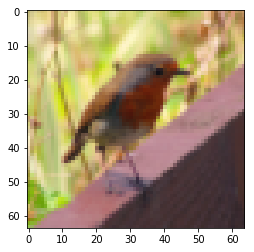

In [14]:
# displaying an image from dataset
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + 
      ". It's a " + classes[train_y[0,index]].decode("utf-8") + " picture.")

In [15]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


### Reshaping and Standardize the Dataset

In [16]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# Section 3: Training the Model

In [0]:
def plot(history, title='Training'):
  # plotting the result
  for key in history.keys():
    if key != 'steps':
      plt.plot(np.squeeze(history[key]))
      plt.ylabel(key)
      plt.xlabel('iterations (per'+ str(history['steps']) + 'step)')
      plt.title(title+' ' + key)
      plt.show()

## Model Training

### He Initialization Model

In [0]:
# initializing the model with hidden units with He Initialization
model = models([12288, 128, 64, 32, 16, 1], he=True)

In [19]:
he_history = model.train(train_x, train_y,
                         num_iters=1200, lr=0.0075,
                         validation_set=(test_x, test_y))

Iter:      0 | Cost: 0.772349 | Accuracy: 0.340000
Iter:    100 | Cost: 0.511838 | Accuracy: 0.620000
Iter:    200 | Cost: 0.396783 | Accuracy: 0.800000
Iter:    300 | Cost: 0.290120 | Accuracy: 0.820000
Iter:    400 | Cost: 0.141823 | Accuracy: 0.760000
Iter:    500 | Cost: 0.079573 | Accuracy: 0.760000
Iter:    600 | Cost: 0.032632 | Accuracy: 0.760000
Iter:    700 | Cost: 0.019630 | Accuracy: 0.740000
Iter:    800 | Cost: 0.013579 | Accuracy: 0.740000
Iter:    900 | Cost: 0.010044 | Accuracy: 0.740000
Iter:   1000 | Cost: 0.007730 | Accuracy: 0.740000
Iter:   1100 | Cost: 0.006212 | Accuracy: 0.740000
Iter:   1199 | Cost: 0.005158 | Accuracy: 0.740000


### L2 Regularization

In [0]:
model = models([12288, 128, 64, 32, 16, 1], lambd=.7)

In [21]:
l2_history = model.train(train_x, train_y,
                         num_iters=1200, lr=0.0075,
                         validation_set=(test_x, test_y))

Iter:      0 | Cost: 1.109942 | Accuracy: 0.360000
Iter:    100 | Cost: 1.010343 | Accuracy: 0.340000
Iter:    200 | Cost: 0.923809 | Accuracy: 0.420000
Iter:    300 | Cost: 0.859836 | Accuracy: 0.400000
Iter:    400 | Cost: 0.792975 | Accuracy: 0.420000
Iter:    500 | Cost: 0.707345 | Accuracy: 0.500000
Iter:    600 | Cost: 0.674077 | Accuracy: 0.500000
Iter:    700 | Cost: 0.495645 | Accuracy: 0.680000
Iter:    800 | Cost: 0.457346 | Accuracy: 0.720000
Iter:    900 | Cost: 0.429222 | Accuracy: 0.760000
Iter:   1000 | Cost: 0.416521 | Accuracy: 0.760000
Iter:   1100 | Cost: 0.409504 | Accuracy: 0.760000
Iter:   1199 | Cost: 0.404616 | Accuracy: 0.760000


### Dropout Layers

In [0]:
model = models([12288, 128, 64, 32, 16, 1], kp=.7)

In [32]:
dropout_history = model.train(train_x, train_y,
                              num_iters=1200, lr=0.0075,
                              validation_set=(test_x, test_y))

Iter:      0 | Cost: 0.707315 | Accuracy: 0.700000
Iter:    100 | Cost: 0.688496 | Accuracy: 0.360000
Iter:    200 | Cost: 0.643141 | Accuracy: 0.360000
Iter:    300 | Cost: 0.635850 | Accuracy: 0.340000
Iter:    400 | Cost: 0.596002 | Accuracy: 0.360000
Iter:    500 | Cost: 0.532553 | Accuracy: 0.340000
Iter:    600 | Cost: 0.519710 | Accuracy: 0.520000
Iter:    700 | Cost: 0.435770 | Accuracy: 0.640000
Iter:    800 | Cost: 0.359935 | Accuracy: 0.660000
Iter:    900 | Cost: 0.324950 | Accuracy: 0.740000
Iter:   1000 | Cost: 0.591665 | Accuracy: 0.640000
Iter:   1100 | Cost: 0.218085 | Accuracy: 0.720000
Iter:   1199 | Cost: 0.179171 | Accuracy: 0.700000


### With All

In [0]:
model = models([12288, 128, 64, 32, 16, 1], he=True, lambd=.2, kp=.7)

In [25]:
all_history = model.train(train_x, train_y,
                          num_iters=1200, lr=0.0075,
                          validation_set=(test_x, test_y))

Iter:      0 | Cost: 0.971648 | Accuracy: 0.520000
Iter:    100 | Cost: 0.846844 | Accuracy: 0.320000
Iter:    200 | Cost: 0.761401 | Accuracy: 0.400000
Iter:    300 | Cost: 0.711434 | Accuracy: 0.520000
Iter:    400 | Cost: 0.640126 | Accuracy: 0.520000
Iter:    500 | Cost: 0.536676 | Accuracy: 0.540000
Iter:    600 | Cost: 0.536463 | Accuracy: 0.620000
Iter:    700 | Cost: 0.454172 | Accuracy: 0.580000
Iter:    800 | Cost: 0.420649 | Accuracy: 0.520000
Iter:    900 | Cost: 0.376861 | Accuracy: 0.680000
Iter:   1000 | Cost: 0.398010 | Accuracy: 0.680000
Iter:   1100 | Cost: 0.349731 | Accuracy: 0.580000
Iter:   1199 | Cost: 0.503147 | Accuracy: 0.640000


### Showing results in graph

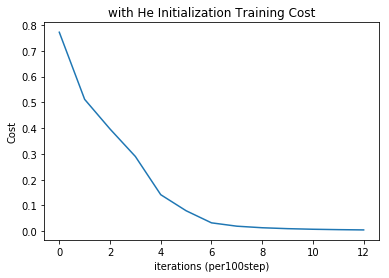

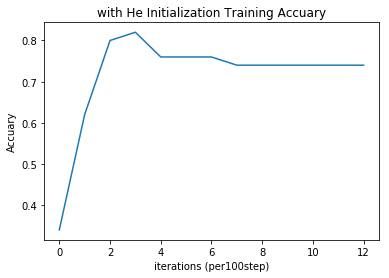

In [26]:
plot(he_history, title='with He Initialization Training')

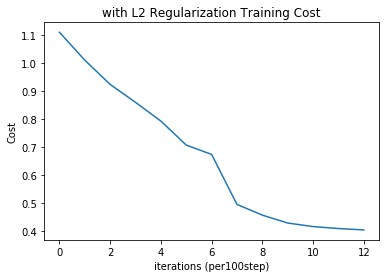

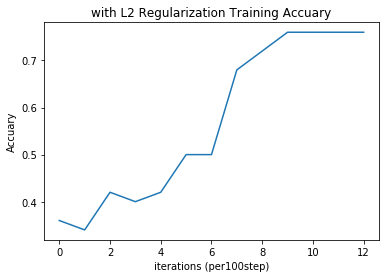

In [27]:
plot(l2_history, title='with L2 Regularization Training')

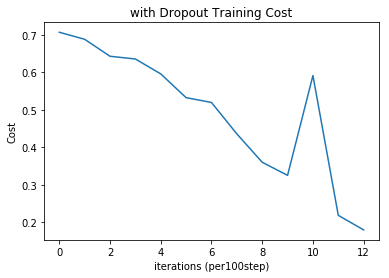

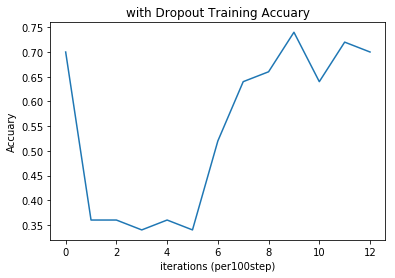

In [33]:
plot(dropout_history, title='with Dropout Training')

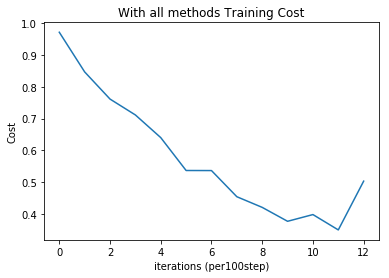

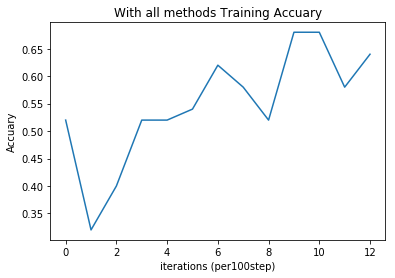

In [30]:
plot(all_history, title='With all methods Training')